# 1. Import libraries and dataset

## Download dataset from Google drive

In [ ]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.

  warnings.warn(

Downloading...

From: https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191

To: /content/vqa_coco_dataset.zip

100% 196M/196M [00:03<00:00, 62.6MB/s]


## If using local file for dataset, run the below line and skip the above

In [ ]:
!unzip -q vqa_coco_dataset.zip

## 1.1 Import libraries

In [ ]:
!pip install timm

In [ ]:
import torch
import torch.nn as nn
import torchtext
import os
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

2024-03-26 17:53:34.210223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 17:53:34.210332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 17:53:34.533091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1.2. Read dataset

In [ ]:
train_data = []
train_set_path = '/kaggle/input/vqa-data/vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

In [ ]:
val_data = []
val_set_path = '/kaggle/input/vqa-data/vaq2.0.DevImages.txt'

with open(val_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

In [ ]:
test_data = []
test_set_path = '/kaggle/input/vqa-data/vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)

In [ ]:
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx_to_classes = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx_to_classes)

{0: 'no', 1: 'yes'}


# 3. Create Pytorch dataset

## 3.1. Define class for custom Pytorch Dataset


*   Initialization: Set up the dataset with necessary parameters, including data list (image paths, questions, and answers), class-to-index mapping for answers, maximum sequence length for questions, image transformations, and the root directory for images.
*   Dataset Size: Through the __len__ method, it provides the total number of entries in the dataset, essential for iterating over the dataset in training and evaluation.
*   Data Retrieval: The __getitem__ method fetches a specific data point by its index. It loads and optionally transforms the image, tokenizes and pads/truncates the question to a fixed length, and converts the answer into a numerical label. This method returns a tuple of the processed image, question, and label, ready for use in model training or inference.

In [ ]:
class VQADataset(Dataset):
    # Initialization
    def __init__(
        self,
        data,
        classes_to_idx,
        img_feature_extractor,
        text_tokenizer,
        device,
        root_dir='/kaggle/input/vqa-data/val2014-resised'
    ):
        self.data = data
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device

    # Dataset Size:

    def __len__(self):
        return len(self.data)

    # Data Retrieval
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')

        if self.img_feature_extractor:
            img = self.img_feature_extractor(images=img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()}

        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question,
                padding="max_length",
                max_length=20,
                truncation=True,
                return_tensors="pt"
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}


        label = self.data[index]['answer']
        label = torch.tensor(
            classes_to_idx[label],
            dtype=torch.long
        ).to(device)

        sample = {
            'image': img,
            'question': question,
            'label': label
        }

        return sample

## 3.2. Load data into Train, Test and Validation set

In [ ]:
# Data pre-processing with Pre-trained model
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:

train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
test_dataset = VQADataset(
    test_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

# 4. Create Model

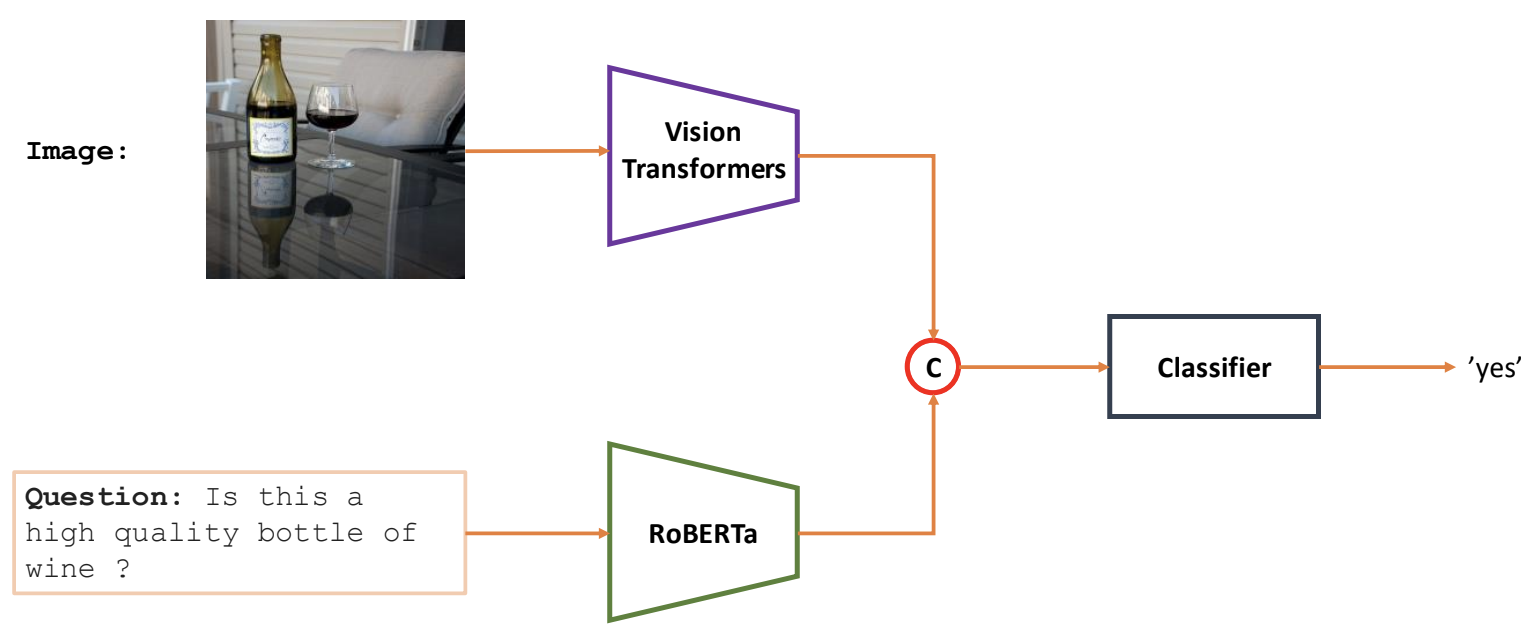

##  4.1. Model's Architecture
* ***VisualEncoder:*** Uses a Vision Transformer (ViT) to encode images.
* ***TextEncoder:*** Employs a RoBERTa model to encode text questions.
* ***Classifier:*** Combines visual and textual features using an LSTM, followed by dropout and a linear layer for classification.
* ***VQAModel:*** Integrates the encoders and classifier, processing both image and question inputs to predict answers.
freeze method: Allows for the selective freezing of encoder components for transfer learning.

In [ ]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [ ]:
class Classifier(nn.Module):
    def __init__(
        self,
        input_size=768*2,
        hidden_size=512,
        n_layers=1,
        dropout_prob=0.2,
        n_classes=2
    ):
        super(Classifier,self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size*2, n_classes)

    def forward(self,x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

In [ ]:
class VQAModel(nn.Module):
    def __init__(
        self,
        visual_encoder,
        text_encoder,
        classifier
    ):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier


    def forward(self, image, answer):
        text_out = self.text_encoder(answer)
        image_out = self.visual_encoder(image)
        x = torch.cat((text_out, image_out), dim=1)
        x = self.classifier(x)

        return x

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n,p in self.visual_encoder.named_parameters():
                p.requires_grad = False
        if textual:
            for n,p in self.text_encoder.named_parameters():
                p.requires_grad = False
        if clas:
            for n,p in self.classifier.named_parameters():
                p.requires_grad = False

## 4.2. Compile model

In [ ]:
n_classes = len(classes)
hidden_size = 1024
n_layers = 1
dropout_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inputs = next(iter(train_loader))

model.eval()
with torch.no_grad():
    image = inputs['image']
    question = inputs['question']
    output = model(image, question)
    print(output.shape)

torch.Size([256, 2])


# 5. Training

## 5.1. Evaluate function

In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

## 5.2. Training function
*   Training: Activates model's training mode. For each epoch, processes data in batches - moving images, questions, and labels to the specified computing device. Then executes model forward passes with the current batch, calculates the loss using the specified criterion, and updates model parameters by performing backpropagation and optimization steps.
*   Validation: Switches the model to evaluation mode and assesses its performance on the validation dataset to compute validation loss and accuracy. Then records the validation loss for each epoch to monitor overfitting and model improvement over time.
*   Adjustment: Modifies the learning rate after each epoch according to a predefined schedule.
*   Logging: Prints a summary of training loss, validation loss, and accuracy after each epoch.
*   Output: Returns histories of training and validation losses for analysis.*   Training: Activates model's training mode. For each epoch, processes data in batches - moving images, questions, and labels to the specified computing device. Then executes model forward passes with the current batch, calculates the loss using the specified criterion, and updates model parameters by performing backpropagation and optimization steps.
*   Validation: Switches the model to evaluation mode and assesses its performance on the validation dataset to compute validation loss and accuracy. Then records the validation loss for each epoch to monitor overfitting and model improvement over time.
*   Adjustment: Modifies the learning rate after each epoch according to a predefined schedule.
*   Logging: Prints a summary of training loss, validation loss, and accuracy after each epoch.
*   Output: Returns histories of training and validation losses for analysis.

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, inputs in enumerate(train_loader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [ ]:
lr = 1e-2
epochs = 50
scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

EPOCH 1:	Train loss: 1.7559	Val loss: 0.7165	Val Acc: 0.4641393442622951
EPOCH 2:	Train loss: 0.7080	Val loss: 0.6882	Val Acc: 0.5394467213114754
EPOCH 3:	Train loss: 0.6938	Val loss: 0.6848	Val Acc: 0.5686475409836066
EPOCH 4:	Train loss: 0.6882	Val loss: 0.6815	Val Acc: 0.5681352459016393
EPOCH 5:	Train loss: 0.6891	Val loss: 0.6815	Val Acc: 0.5665983606557377
EPOCH 6:	Train loss: 0.6797	Val loss: 0.6845	Val Acc: 0.5660860655737705
EPOCH 7:	Train loss: 0.6712	Val loss: 0.6775	Val Acc: 0.5706967213114754
EPOCH 8:	Train loss: 0.6641	Val loss: 0.6774	Val Acc: 0.579405737704918
EPOCH 9:	Train loss: 0.6549	Val loss: 0.6764	Val Acc: 0.5814549180327869
EPOCH 10:	Train loss: 0.6481	Val loss: 0.6670	Val Acc: 0.5973360655737705
EPOCH 11:	Train loss: 0.6293	Val loss: 0.6747	Val Acc: 0.5927254098360656
EPOCH 12:	Train loss: 0.6243	Val loss: 0.6739	Val Acc: 0.6014344262295082
EPOCH 13:	Train loss: 0.6074	Val loss: 0.6849	Val Acc: 0.5942622950819673
EPOCH 14:	Train loss: 0.6001	Val loss: 0.6794	Va

## 5.3. Visualiztion of training result

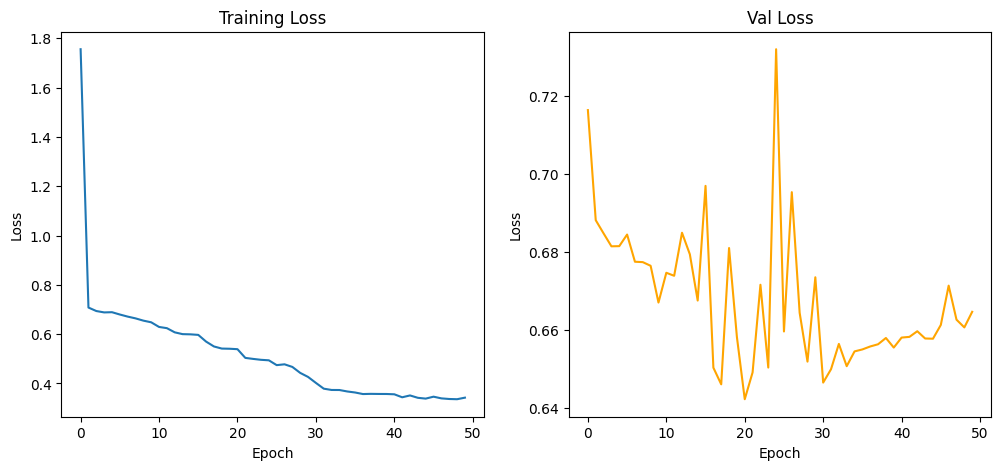

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

# 6. Evaluation

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6854508196721312
Test accuracy:  0.6726013847675568
